<a href="https://colab.research.google.com/github/dohyun93/hongong_mldl/blob/main/9_2_%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9C%BC%EB%A1%9C_IMDB%EB%A6%AC%EB%B7%B0_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB 리뷰 RNN으로 감성 분석 해보기

> imdb.com 라는 사이트에서 영화에 대한 리뷰 데이터를 갖고 긍정/부정 평가인지 분류하는 순환신경망 모델을 개발해보자.

> ```자연어처리 (NLP, Natural Language Processing)```은 컴퓨터로 인간의 언어를 처리하는 인공지능 분야이다. ```NLP 분야에서는 훈련 데이터를 말뭉치(corpus)``` 라고 부른다.

> 이 절에서는 코퍼스를 두 가지 방법으로 변형하여 순환신경망에 주입해본다. 1) ```원-핫 인코딩```과 ```2) 단어 임베딩```이 바로 그것이다.

> 컴퓨터는 텍스트 자체를 처리할 수 없다. 합성곱 신경망에서 이미지를 처리할 때는 이미지 자체가 정수로 이루어진 픽셀의 배열이었기 때문에 255.0으로 나누어주는 표준화과정만 거쳤지만, ```순환신경망에서는 텍스트를 숫자로 바꿔주는 작업이 필요하다.```

> 텍스트로 이뤄진 샘플을 숫자로 어떻게 매핑할까? 샘플을 이루는 텍스트에서 구두점을 지우고 소문자로 변환한 뒤, 공백으로 구분한다고 하면 각 분리된 단어를 ```토큰(token)``` 이라고 부른다. 이 토큰을 각각 독립적으로 정수를 할당하면 텍스트를 숫자로 변환할 수 있다. 이 때, 이 정수는 그 자체로 어떤 의미를 갖거나, 다른 정수와 관계를 갖지 않는다. ```정리하면, 하나의 샘플은 여러개의 토큰으로 이루어져 있고, 1개의 토큰이 하나의 타임스텝에 해당한다. (시퀀스 길이 = 타임스텝 길이 = 샘플 길이)```

> 한글은 영어와 다르게 형태소 분석을 통해 토큰을 만드나, 이 책에서는 범위에서 벗어난다. 파이썬 라이브러리를 활용한 머신러닝 책에서 다시 살펴보자. (KoNLPy)

> 토큰에 정수를 할당할 때, 정수 중 몇 개는 특정한 용도로 예약되어 있는 경우가 많다. 가령, 0은 패딩, 1은 문장의 시작, 2는 어휘 사전에 없는 토큰을 나타낸다. ```훈련 세트에서 고유한 단어를 뽑아 만든 목록을 어휘 사전``` 이라고 말한다.




In [27]:
# 실제 IMDB 리뷰 데이터셋은 영어로 된 문장이지만, 편리하게도 tf에는 이미 정수로 바꾼 데이터가 포함되어있다.
# tensorflow.keras.datasets 패키지 아래 imdb 모듈을 임포트해서 이 데이터를 적재해보자.
# 여기서는 가장 자주 등장하는 단어 500개만 사용한다.

from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [28]:
# 코퍼스가 1차원 배열인게 다소 의아하다.
# 첫 번째, 세 번째 코퍼스 샘플(리뷰)들을 출력해보자.
print(train_input[0])
print(len(train_input[0]))
print(train_input[2])
print(len(train_input[2]))

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
218
[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 2, 54, 61, 369, 13, 71, 149, 14, 22, 112, 4, 2, 311, 12, 16, 2, 33, 75, 43, 2, 296, 4, 86, 320, 35, 2,

In [29]:
# 즉, 코퍼스는 파이썬 리스트 객체를 원소로 갖는 1차원 리스트인 것을 알 수 있다.
# 이 리뷰 하나 하나가 샘플이다.

# 앞서 num_words=500으로 지정했기 때문에, 코퍼스에 존재하는 가장 많이 등장하는 500개의 단어만 어휘사전에 들어가있으며, 
# 여기에 없는 단어는 모두 2로 표시되어 나타난다.

# 이번에는 타깃 데이터를 출력해보자.
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [30]:
# imdb 데이터로 하고자 하는 것은 샘플데이터(리뷰)가 영화에 대한 긍정 평가인지, 부정 평가인지를 판단하는 것이다.
# 그러면 이진 분류문제로 볼 수 있을 것이고, 타깃값이 0이면 부정평가, 1이면 긍정평가로 나누어진다.

# 이제 훈련세트를 훈련/검증 세트로 나누어보자. 
# 25000개가 훈련세트였으므로, 0.2를 검증세트비율로 잡으면 20000개의 훈련세트, 5000개의 검증 세트로 나누어진다.

from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, random_state=30, test_size=0.2)

In [31]:
# 훈련 세트에 대해 몇 가지 조사를 해보자.
# 1. 먼저 각 리뷰의 길이를 계산해 넘파이 배열에 담는다.
# 그 이유는 평균적인 리뷰 길이와, 가장 짧은 리뷰의 길이, 그리고 가장 긴 리뷰의 길이를 확인하고 싶기 때문이다.

import numpy as np
lengths = np.array([len(x) for x in train_input])

# 평균과 중간값 출력.
print("1. 최소 코퍼스길이: ", np.min(lengths))
print("2. 최대 코퍼스길이: ", np.max(lengths))
print("3. 평균 코퍼스길이: ", np.mean(lengths))
print("4. 중간 코퍼스길이: ", np.median(lengths))

1. 최소 코퍼스길이:  11
2. 최대 코퍼스길이:  2494
3. 평균 코퍼스길이:  238.5638
4. 중간 코퍼스길이:  178.0


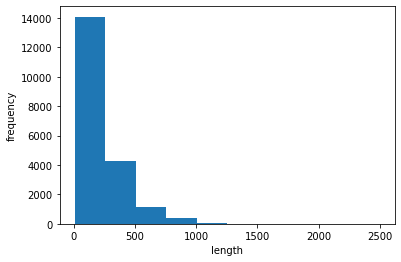

In [32]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [33]:
# 1. 최소 코퍼스길이:  11
# 2. 최대 코퍼스길이:  2494
# 3. 평균 코퍼스길이:  238.5638
# 4. 중간 코퍼스길이:  178.0

# 와 위 히스토그램을 비교해보았을 때, 20000개 코퍼스에서 대부분의 리뷰 길이는 300미만이다.
# 평균 238이 중간값 178보다 높은 이유는 오른쪽 끝에 아주 긴 데이터가 있기 때문이다.

# 리뷰는 대부분 짧기 때문에, 이 예제에서는 중간값보다 훨씬 짧은 100개의 단어만 사용한다.
# 하지만 여전히 100개의 단어보다 작은 코퍼스가 있다. 이런 리뷰들의 길이를 100에 맞추기 위해 '패딩'이 필요하다.
# 보통 패딩을 나타내는 토큰으로는 0을 사용한다.

# 수동으로 훈련 세트에 있는 20000개의 리뷰를 순회하면서, 길이가 100이 되도록 자르거나, 0으로 패딩할 수 있지만,
# 케라스에는 시퀀스 데이터의 길이를 맞추는 pad_sequences() 함수를 제공한다.
# 이를 활용해 train_input 의 길이를 100으로 맞추어보자.

from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)

print(train_seq.shape)

(20000, 100)


In [34]:
# train_input 은 파이썬 리스트의 1D 배열이었지만, 길이를 100으로 맞춘 train_seq은 이제 (20000,100)의 2D 배열이 되었다.
# 20000: 샘플 개수
# 100: 토큰(타임스텝) 개수

print(train_seq[0])

[193   2  19  44  14 123   9  23   4 278   2   2   2   2  18   2   2   2
   2 126   2   2  21  25 124  51  13  66 423  12  12  16 275  12  16 204
  12  66  66   2   5  15  93  56  18  32   4   2   4 123  16   2   2   2
   2 221 253   8 168  33  25 124  12  16  64  23 280   6   2  13 100 193
  12 280   6   2   5 168   2   8  12   5 358  12  13  80   2  94   2  21
  13 482   2  80  30   2  14 145   8 113]


In [36]:
# 0이 없는 것으로 보아 이 코퍼스의 길이는 원래 100이 넘었던것으로 보인다.
# 앞 부분이 잘렸는지, 뒷 부분이 잘렸는지 어떻게 알 수 있을까?
# 원래 코퍼스의 마지막 10개 토큰을 출력해보자.

print(train_input[0][-10:])

[13, 482, 2, 80, 30, 2, 14, 145, 8, 113]


In [46]:
# train_seq 의 마지막과 동일하므로, 앞부분이 잘린것을 알 수 있다.
# pad_sequences() 함수는 기본적으로 maxlen보다 긴 시퀀스는 앞 부분을 자른다.
# 그 이유는 유의미한 정보가 시퀀스의 뒷 부분에 있을거라고 기대하기 때문이다.
# 만약 이 설정을 바꾸고싶다면, 'truncating' 매개변수를 'pre'가 아닌 'post'로 바꾸면 된다.

# [3] 를 출력해보자.
print(train_seq[3])

[  0   0   0   0   0   1 103   4   2   2   7   2   5   2   2 189 102   2
  40   6   2  11   4   2   2 182   7 189 102   4   2   9  32  11 108  40
   2   2   2   6 248  40 365  78 398  21   2   5   2  60 433  13 161 332
   4   2   2 274  21 146 252  15   4   2   7   4   2  37   2  94 452 161
  28  76  11   2  19  14 394 365   2  12  33 101   2   2 335   2  18   6
   2   2 314  11   6   2  20   2 241 158]


In [47]:
# 앞 부분에 0이 있는걸 봐서 이 시퀀스는 100보다 작은 길이라는걸 알 수 있다.
# 패딩도 'truncating' 처럼 앞부분에 패딩을 추가한다.
# 이 설정은 'padding' 매개변수의 값을 'pre' 가 아닌 'post'로 바꾸어 변경이 가능하다.

# 하지만, 시퀀스의 마지막에 있는 단어가 셀의 출력인 '은닉 상태'에 가장 큰 영향을 미치게 되므로,
# 마지막에 패딩을 추가하는 것은 일반적으로 선호하지 않는다.

# 검증 세트의 길이도 100으로 맞추자.
val_seq = pad_sequences(val_input, maxlen=100)

In [49]:
# 순환 신경망 만들기

# 케라스는 여러가지 순환층 클래스를 제공한다.
# 그중 가장 간단한 것은 'SimpleRNN' 클래스이다.
# 이 클래스를 갖고 IMDB 리뷰 감성분석 모델을 만들어보자.

# keras.Sequential() 클래스는 참고로, 일반적인 인공신경망이나 합성곱 신경망, RNN 모두 사용할 수 있다.
# 이름 때문에 순환신경망을 만드는 것이라고 착각하지 말자. 단순히 층 순서대로 인공신경망을 만들 때 사용할 수 있는 클래스이다.

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 입력층 다음 순환층에 입력 차원을 (100, 500)로 지정했다.
# maxlen으로 코퍼스의 최대 길이를 100으로 지정했기 때문에, (샘플순서, 100)으로 입력되는 이유로
# 입력 차원의 첫 번째 차원을 100으로 지정했다. 그렇다면 500은 뭘까?

# imdb.load_data() 함수에서 500개의 단어만 사용하도록 지정했기 때문에, 고유한 단어는 모두 500개이다.
# 따라서, 훈련 데이터에 포함될 수 있는 정수값의 범위는 0부터 499까지인 500개이기 때문에,
# 길이 100인 코퍼스의 각 토큰에 대해 원-핫 인코딩으로 0~499표현하기 위해 (100, 500)으로 입력 차원을 지정한 것이다.

# 8은 순환층의 뉴런 수이다.

# 케라스에는 원-핫 인코딩을 위한 클래스도 존재한다.
train_oh = keras.utils.to_categorical(train_seq)
print(train_seq.shape)
print(train_oh.shape)

(20000, 100)
(20000, 100, 500)


In [58]:
# 100 개 각 토큰을 표현하는 정수마다 0~499 범위의 원-핫 인코딩 되었기 때문에 마지막 차원에 500이 추가되었다.
print(train_oh[0][1][:])
print(train_seq[0][1])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [59]:
# [2] 코퍼스를 확인한 결과, 원-핫 인코딩이 잘 된것을 알 수 있다.
# val_seq도 같은 방식으로 원-핫 인코딩 하자.
val_oh = keras.utils.to_categorical(val_seq)

In [60]:
# model 구조를 보자.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 4072      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [62]:
# 입력 토큰이 500차원의 원-핫 인코딩 배열이고, 순환층의 뉴런 수가 8개이므로,
# 4000개 w_x 가 생성되며, b는 뉴런수이므로 8개, 그리고 순환층에 다시 입력되는 은닉 상태 8에 뉴런수 8을 곱한 64를 모두 더하면
# 4072개가 순환층에 필요한 모델 파라미터의 개수가 된다.

# 그 다음 순환층과 출력층 사이 8개, 출력층 편향 1개인 9개가 마지막 출력층과 순환층 사이의 모델 파라미터이다.

# 이제 이 순환 신경망을 훈련시켜보자.
# optimizer RMSprop 의 lr: 0.0001 (default: 0.001)
# epochs = 100.
# minibatch size = 64 (default: 32)
# checkpoint, early stopping used.

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 12s 36ms/step - loss: 0.6987 - accuracy: 0.4941 - val_loss: 0.7003 - val_accuracy: 0.4774
Epoch 2/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6950 - accuracy: 0.5048 - val_loss: 0.6979 - val_accuracy: 0.4852
Epoch 3/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6930 - accuracy: 0.5109 - val_loss: 0.6961 - val_accuracy: 0.4930
Epoch 4/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6915 - accuracy: 0.5198 - val_loss: 0.6949 - val_accuracy: 0.4956
Epoch 5/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6901 - accuracy: 0.5290 - val_loss: 0.6941 - val_accuracy: 0.5014
Epoch 6/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6886 - accuracy: 0.5365 - val_loss: 0.6936 - val_accuracy: 0.5100
Epoch 7/100
313/313 [==============================] - 11s 35ms/step - loss: 0.6867 - accuracy: 0.5466 - val_loss: 0.6925 - val_ac

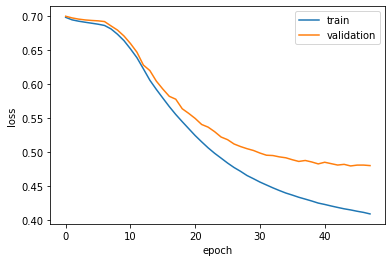

In [64]:
# 훈련 세트에 대한 정확도는 79.4, 검증세트에 대한 정확도는 75.92 정도로 뛰어난 성능은 아니지만
# 어느정도 감상평을 분류하고는 있다.

# 훈련 손실과 검증 손실을 그래프로 그려보자.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

In [65]:
# 훈련 손실은 꾸준히 감소하고 있지만, 검증 손실은 25번째 에포크부터 감소가 둔해지고 있다.
# 적절한 에포크에서 훈련을 멈춘 것으로 봐도 될 것 같다.

# 여기서 한 가지 생각해볼 점은, 정수로 표현된 코퍼스 내 각 샘플의 각 토큰을 원-핫 인코딩하였을 때, 
# 입력데이터의 차원이 엄청 커진다는 단점이 있다는 것이다.

print(train_seq.nbytes)
print(train_oh.nbytes)

8000000
4000000000


In [66]:
# 사실 이런 원-핫 인코딩보다 순환신경망에서 더 좋은 단어 표현 방법이 있다.
# 단어 임베딩을 공부해보자.

# 단어 임베딩은 각 토큰을 고정된 크기의 실수 벡터로 바꾸어 준다.
# 즉, 단어 임베딩을 통해 (100,)의 샘플을 (100, 20)처럼 고정된 크기의 차원을 추가해준다.

# 이 단어 임베딩은 원-핫 인코딩에 비해 훨씬 의미있는 값으로 채워져 있어서 원-핫 인코딩 대비 더 좋은 성능을 보인다.
# keras.layers.Embedding 클래스를 추가해서 모델을 다시 만들어보자.

model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
# 1. imdb.load_data(num_words=500) 으로 어휘 사전의 크기를 500으로 지정했기 때문에, 첫 인자 어휘사전의 크기를 500으로 지정한다.
# 2. 임베딩 벡터의 크기를 16으로 선언한다.
# 3. input_length 매개변수로 입력 시퀀스의 길이 100을 지정한다.

model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [67]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [69]:
# 1. Embedding 층
# 입력: (100,)
# 출력: (100, 16)
# 500개 어휘 사전에 대해 16개 길이의 벡터를 갖는 단어 임베딩을 학습하기 위해 500*16 = 8000개의 모델 파라미터 존재.

# 2. 순환층
# 입력: (16,)
# 출력: (8,)
# 임베딩 벡터의 크기가 16이므로, 순환층 뉴런 수 8와 곱해 128개의 모델 파라미터 존재.
# 또한, 자기 자신에게 포워드 되는 모델 파라미터가 8*8 = 64 개 존재하며 절편 8개 존재하므로 200개.

# 3. Dense
# 8개 뉴런과 1개 출력층의 사이 8개와 편향 1개해서 9개 존재.

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(metrics=['accuracy'], optimizer=rmsprop, loss='binary_crossentropy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, train_target, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb], epochs=100, batch_size=64)


Epoch 1/100
313/313 [==============================] - 7s 19ms/step - loss: 0.6902 - accuracy: 0.5368 - val_loss: 0.6759 - val_accuracy: 0.6026
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6649 - accuracy: 0.6291 - val_loss: 0.6561 - val_accuracy: 0.6518
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6400 - accuracy: 0.6813 - val_loss: 0.6297 - val_accuracy: 0.6952
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6152 - accuracy: 0.7125 - val_loss: 0.6109 - val_accuracy: 0.7190
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5940 - accuracy: 0.7333 - val_loss: 0.5937 - val_accuracy: 0.7280
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5747 - accuracy: 0.7469 - val_loss: 0.5785 - val_accuracy: 0.7386
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5564 - accuracy: 0.7580 - val_loss: 0.5607 - val_accuracy:

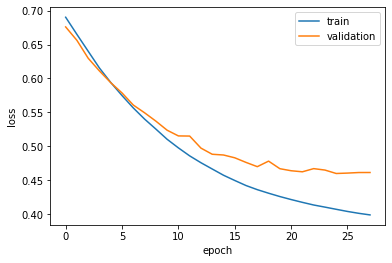

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

In [72]:
# 원-핫 인코딩 대비 성능이 아주 약간 개선되었고, 검증 세트의 손실도 더 감소하지 않아서 적절히 조기종료 된 것으로 보인다.
# 순환층의 가중치 개수도 훨씬 적어지고(4072->200), 훈련 세트의 크기도 훨씬 줄어들었다. (train_oh -> train_seq)
# 훈련 손실이 계속 감소하는 것으로 보여 개선의 여지가 있을 것 같은데, 9-3 장에서 확인해보자.